# Local loneliness variation based on distance
Not on the number of neighboors

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import geopandas as gpd
import shapely 
import sklearn as sk
import sklearn.covariance
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as smstats

/usr/bin/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
data = pd.read_csv('data/MSOA_summary.csv',index_col=0)
data = gpd.GeoDataFrame(data = data,
                            crs = 'epsg:27700', 
                            geometry = data['geometry'].apply(shapely.wkt.loads))

<Figure size 432x288 with 0 Axes>

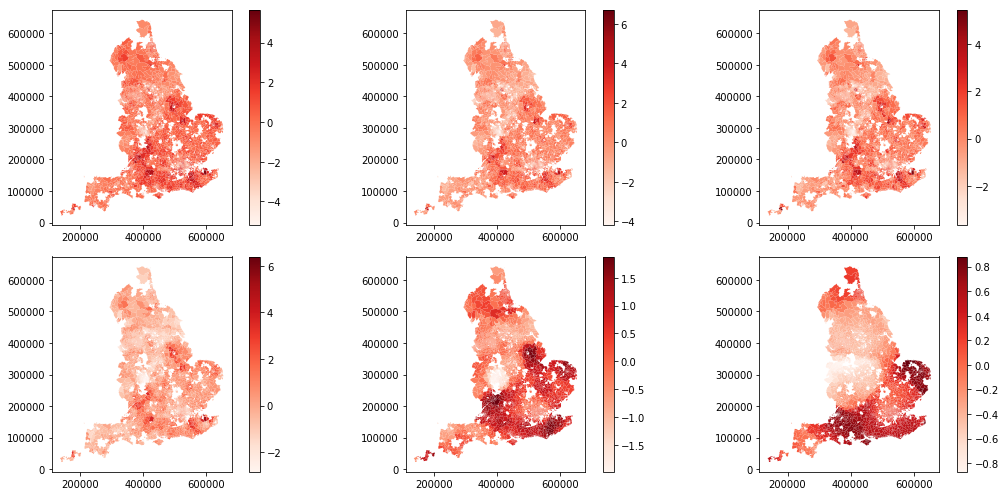

In [3]:
current_cmap = matplotlib.cm.get_cmap()
plt.set_cmap('Reds')


fig = plt.figure(figsize=(15,7))
data.plot(column='loneliness', ax = fig.add_subplot(2,3,1), legend=True)
data.plot(column='loneliness_mean_3000',  ax = fig.add_subplot(2,3,2) , legend=True)
data.plot(column='loneliness_mean_5000',  ax = fig.add_subplot(2,3,3) , legend=True)
data.plot(column='loneliness_mean_10000', ax = fig.add_subplot(2,3,4), legend=True)
data.plot(column='loneliness_mean_30000', ax = fig.add_subplot(2,3,5), legend=True)
data.plot(column='loneliness_mean_100000', ax = fig.add_subplot(2,3,6), legend=True)
fig.tight_layout()
fig.savefig("plots/loneliness_mean.pdf", bbox_inches='tight')

# Local desirability
## plots


In [ ]:
current_cmap = matplotlib.cm.get_cmap()
plt.set_cmap('Greens')

fig = plt.figure(figsize=(15,7))
data.plot(column='desirability', ax = fig.add_subplot(2,3,1), legend=True)
data.plot(column='desirability_mean_3000',  ax = fig.add_subplot(2,3,2) , legend=True)
data.plot(column='desirability_mean_5000',ax = fig.add_subplot(2,3,3), legend=True)
data.plot(column='desirability_mean_10000',ax = fig.add_subplot(2,3,4), legend=True)
data.plot(column='desirability_mean_30000', ax = fig.add_subplot(2,3,5), legend=True)
data.plot(column='desirability_mean_100000', ax = fig.add_subplot(2,3,6), legend=True)
fig.tight_layout()
fig.savefig("plots/desirability_mean.pdf", bbox_inches='tight')


fig = plt.figure(figsize=(15,7))
data.plot(column='desirability', ax = fig.add_subplot(2,3,1), legend=True)
data.plot(column='desirability_max_3000',  ax = fig.add_subplot(2,3,2) , legend=True)
data.plot(column='desirability_max_5000',ax = fig.add_subplot(2,3,3), legend=True)
data.plot(column='desirability_max_10000',ax = fig.add_subplot(2,3,4), legend=True)
data.plot(column='desirability_max_30000', ax = fig.add_subplot(2,3,5), legend=True)
data.plot(column='desirability_max_100000', ax = fig.add_subplot(2,3,6), legend=True)
fig.tight_layout()
fig.savefig("plots/desirability_max.pdf", bbox_inches='tight')

# Test local scales
## One big regression

In [ ]:
Y = data['loneliness'] 
l = []
columns = ['desirability_max_5000', 
           'desirability_max_10000', 
           'desirability_max_30000', 
           'desirability_max_100000',
           'desirability_mean_5000',
           'desirability_mean_10000', 
           'desirability_mean_30000', 
           'desirability_mean_100000']
            
labels = ['max 5000', 'max 10000', 'max 30000', 'max 100000',
         'mean 5000', 'mean 10000', 'mean 30000', 'mean 100000', 'unmodified']
for col in columns:
    x1 = data['desirability']  - data[col] - np.mean(data['desirability']  / data[col] )
    l.append(list(x1))


x1 = data['desirability'] - np.mean(data['desirability'])
l.append(list(x1))

X = sm.add_constant(np.transpose(np.array(l)))
est = sm.OLS(Y, X)
est2 = est.fit()



**p values**

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
plot = ax.plot(est2.pvalues[1:], ls='', marker='o')
ax.plot()
ax.set_yscale('log')
ax.set_ylim(bottom = est2.pvalues[1:].min()/100000,top=1.1)
ax.axhline(y=0.1, ls='-')
ax.axhline(y=0.05, ls='--')
ax.axhline(y=0.01, ls='-.')

for i, txt in enumerate(est2.pvalues[1:]):
    ax.annotate('p={:.0e}'.format(txt), (list(range(len(est2.pvalues[1:])))[i]-0.1, est2.pvalues[1:][i]*0.0001))

plt.title('p-values for multiple variable regression    (R^2 = ' + str(round(est2.rsquared,3)) + ')')
plt.xlabel('Explanatory variable')
plt.ylabel('p-value')
y_pos = np.arange(len(labels))
plt.xticks(y_pos, labels, rotation=-20, ha='left')

#plot = plt.plot(np.abs(est2.params))
print(est2.rsquared)
print(est2.pvalues)

#fig.savefig("plots/p_value_multi_variable_regression_subset.pdf", bbox_inches='tight')

**residual analysis**

In [ ]:
outlier_pvalue = est2.outlier_test()['bonf(p)']
outliers = np.where((outlier_pvalue<0.05))[0]
print('outliers : ' + str(outliers))

In [ ]:
sorted_residual = np.sort(est2.get_influence().resid_studentized_internal)
theoretical_quantiles = stats.probplot(sorted_residual, dist = 'norm', fit = False)[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = plt.scatter(sorted_residual,theoretical_quantiles, edgecolor = 'k',facecolor = 'none', marker = '.')
ax.plot([np.min([sorted_residual,theoretical_quantiles]),
         np.max([sorted_residual,theoretical_quantiles])]
        ,[np.min([sorted_residual,theoretical_quantiles]),np.max([sorted_residual,theoretical_quantiles])], color = 'r', ls = '--')


In [ ]:
fig = plt.figure(figsize=(130,60))
fig = sm.graphics.plot_partregress_grid(est2)
fig.tight_layout(pad=1.0)

In [ ]:
exog = X
[smstats.outliers_influence.variance_inflation_factor(exog,i) for i in range(len(columns))] 

boxcox transformation

In [ ]:
loneliness = data['loneliness'] + abs(min(data['loneliness'])) + 4
loneliness, l = stats.boxcox(loneliness)

Y = loneliness
est = sm.OLS(Y, X)
est2 = est.fit()


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = ax.plot(est2.pvalues[1:], ls='', marker='o')
ax.plot()
ax.set_yscale('log')
ax.set_ylim(bottom = est2.pvalues[1:].min()/10,top=1.1)
ax.axhline(y=0.1, ls='-')
ax.axhline(y=0.05, ls='--')
ax.axhline(y=0.01, ls='-.')


    
#plot = plt.plot(np.abs(est2.params))
print(est2.rsquared)
print(est2.pvalues)

similar results

## Separate regressions

In [ ]:
coeffs = np.array([])
pvalues = np.array([])
rsquared = np.array([])
x_matrix = []
for col in columns:
    x1 = data['desirability']  / data[col] **5
    X = sm.add_constant(np.transpose(np.array([x1])))
    est = sm.OLS(Y, X)
    est2 = est.fit()
    coeffs = np.append(coeffs, [est2.params[1]])
    pvalues = np.append(pvalues, [est2.pvalues[1]])
    rsquared = np.append(rsquared, [est2.rsquared])
    x_matrix.append(x1)


x1 = data['desirability'] 
X = sm.add_constant(np.transpose(np.array([x1])))
est = sm.OLS(Y, X)
est2 = est.fit()
coeffs = np.append(coeffs, [est2.params[1]])
pvalues = np.append(pvalues, [est2.pvalues[1]])
rsquared = np.append(rsquared, [est2.rsquared])
x_matrix.append(x1)


In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
c = np.array([[1,0,0],[0,1,0]])
ax.set_ylim((0,max(abs(coeffs))*1.1))
plot = ax.scatter(x=list(range(len(coeffs))),
                  y=abs(coeffs), marker='o', color = c[(pvalues<1e-5).astype(int)], s = -np.log(pvalues)*5)
print(pvalues)
print()
for i, txt in enumerate(pvalues):
    ax.annotate('p={:.0e}'.format(txt), (list(range(len(coeffs)))[i], abs(coeffs)[i]+0.1))


In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
c = np.array([[1,0,0],[0,1,0]])
ax.set_ylim((0,max(abs(rsquared))*1.1))
plot = ax.scatter(x=list(range(len(rsquared))),
                  y=abs(rsquared), marker='o', color = c[(pvalues<1e-5).astype(int)], s = -np.log(pvalues)*5)
plt.title('R^2 and p-values for single variable regressions')
plt.xlabel('Explanatory variable')
plt.ylabel('R^2')
y_pos = np.arange(len(labels))
plt.xticks(y_pos, labels, rotation=-20, ha='left')

for i, txt in enumerate(pvalues):
    ax.annotate('p={:.0e}'.format(txt), (list(range(len(rsquared)))[i], abs(rsquared)[i]+0.001))

#fig.savefig("plots/r_2_p_single_variable_regression.pdf", bbox_inches='tight')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

df = (1/data[columns].div(data['desirability'],axis=0))
df['desirability'] =  data['desirability']

cax = ax.matshow(df.corr(), vmin=0, vmax=1)
fig.colorbar(cax)

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
res = plt.xticks(rotation=30, ha='left')
res = plt.title('Correlation of variables\n\n\n')

#fig.savefig("plots/correlation_of_variables.pdf", bbox_inches='tight')

In [ ]:
print(data)